In [1]:
import pandas as pd
import time
import numpy as np
import copy
import glob
import sys, os
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from sklearn.metrics import precision_score, recall_score
import pickle
from sklearn import preprocessing
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from folktables import ACSDataSource, ACSEmployment,ACSIncome
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import os
from torch.utils.data import Dataset
import numpy as np
import torch.nn.functional as F
import pandas as pd
from scipy.stats import multivariate_normal
import torch, random, copy, os
from collections import OrderedDict


In [2]:
 class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 14 : input shape
        # 9-> we have 9 columns in data 
        self.layer1 = nn.Linear(14, 512)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x



# FAIR FED

In [3]:
path_2="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/testing_models/global_model_2.pt"

In [4]:
temp_path_data="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/"

with open(temp_path_data+"/valid_testing_client.pkl", "rb") as f:
    valset = pickle.load(f)
 
with open(temp_path_data+"/testing_client.pkl", "rb") as f:
    testset  = pickle.load(f)


In [5]:
import torch

if torch.cuda.is_available():
    print("CUDA is available.")
else:
    # CUDA is not available
    print("CUDA is not available. Running on CPU.")


CUDA is available.


In [6]:
model=DeepNet()
model.load_state_dict(torch.load(path_2))
model.eval()

DeepNet(
  (layer1): Linear(in_features=14, out_features=512, bias=True)
  (act1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (act2): ReLU()
  (layer3): Linear(in_features=256, out_features=60, bias=True)
  (act3): ReLU()
  (output): Linear(in_features=60, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [7]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        

In [8]:
import torch

size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
pr_FF=[]
rc_FF=[]
ac_FF=[]
selected_clients = [0, 1, 2, 3]
client_metrics = []

# Assuming model and criterion are already defined and loaded onto the GPU
model = model.to(device)
criterion = criterion.to(device)

for i in range(len(selected_clients)):
    for inputs, targets, sens in testset[i]:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(testset)
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels)
    
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global Recall: {recall:.5%}")
    print("\n")

    data = {
        'Client ID': i,
        'Accuracy': acc,
        'Precision': precision,
        'Recall':recall,
        }
    client_metrics.append(data)

df_ff = pd.DataFrame(client_metrics)
df_ff


Global Testing Accuracy: 42.69618%
Global Precision: 42.69618%
Global Recall: 100.00000%


Global Testing Accuracy: 39.62466%
Global Precision: 39.62466%
Global Recall: 100.00000%


Global Testing Accuracy: 40.12552%
Global Precision: 40.12552%
Global Recall: 100.00000%


Global Testing Accuracy: 40.52740%
Global Precision: 40.52740%
Global Recall: 100.00000%




,Client ID,Accuracy,Precision,Recall
0,0,0.426962,0.426962,1.0
1,1,0.396247,0.396247,1.0
2,2,0.401255,0.401255,1.0
3,3,0.405274,0.405274,1.0


# FedAVG

In [9]:
import torch

size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
final_fairness = []
selected_clients = [0, 1, 2, 3]

path_2="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/testing_models/global_model.pt"

model=DeepNet()
model.load_state_dict(torch.load(path_2))
model.eval()
client_metrics=[]

# Assuming model and criterion are already defined and loaded onto the GPU
model = model.to(device)
criterion = criterion.to(device)

for i in range(len(selected_clients)):
    for inputs, targets, sens in testset[i]:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(testset)
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels)
    
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global Recall: {recall:.5%}")
    print("\n\n")
    
    data = {
        'Client ID': i,
        'Accuracy': acc,
        'Precision': precision,
        'Recall':recall,
        }
    client_metrics.append(data)

df_FA = pd.DataFrame(client_metrics)
df_FA

Global Testing Accuracy: 42.69618%
Global Precision: 42.69618%
Global Recall: 100.00000%



Global Testing Accuracy: 39.62466%
Global Precision: 39.62466%
Global Recall: 100.00000%



Global Testing Accuracy: 40.12552%
Global Precision: 40.12552%
Global Recall: 100.00000%



Global Testing Accuracy: 40.52740%
Global Precision: 40.52740%
Global Recall: 100.00000%





,Client ID,Accuracy,Precision,Recall
0,0,0.426962,0.426962,1.0
1,1,0.396247,0.396247,1.0
2,2,0.401255,0.401255,1.0
3,3,0.405274,0.405274,1.0


# classical model

In [10]:
 
class DeepNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 14 : input shape
        # 9-> we have 9 columns in data 
        self.layer1 = nn.Linear(14, 512)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.layer2 = nn.Linear(512, 256)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x


In [11]:
temp_path_data="/home/chiragapandav/Downloads/Hiwi/Improving-Fairness-via-Federated-Learning/FedFB/"


with open(temp_path_data+"/Normal_training_data.pkl", "rb") as f:
    nor_trainData = pickle.load(f)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model=DeepNet()

model = model.to(device)
criterion = criterion.to(device)

In [13]:
# num_epochs=10
# for epoch in range(num_epochs):
#     # Set the model to training mode
#     model.train()

#     for inputs, labels, sens in nor_trainData:
        
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs).to(device)
#         loss = criterion(outputs, labels.float())
#         loss.backward()
#         optimizer.step()

In [14]:
# torch.save(model.state_dict(), "normal_model.pth")

In [15]:
import torch

size = 0
loss = 0
correct = 0
total = 0
predicted_labels = []
true_labels = []
final_fairness = []
selected_clients = [0, 1, 2, 3]

model=DeepNet()
model.load_state_dict(torch.load("normal_model.pth"))
model.eval()

client_metrics=[]
# Assuming model and criterion are already defined and loaded onto the GPU
model = model.to(device)
criterion = criterion.to(device)

for i in range(len(selected_clients)):
    for inputs, targets, sens in testset[i]:
        inputs, targets = inputs.to(device), targets.to(device)
        
        outputs = model(inputs)
        loss += criterion(outputs, targets)
        predicted = outputs > 0.5

        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(targets.cpu().numpy())
        
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    
    loss = loss / len(testset)
    acc = correct / total
    
    precision = precision_score(true_labels, predicted_labels, zero_division=0.0)
    recall = recall_score(true_labels, predicted_labels)
    
    print(f"Global Testing Accuracy: {acc:.5%}")
    print(f"Global Precision: {precision:.5%}")
    print(f"Global Recall: {recall:.5%}")
    print("\n\n")

    data = {
        'Client ID': i,
        'Accuracy': acc,
        'Precision': precision,
        'Recall':recall,
        }
    client_metrics.append(data)

df_CD = pd.DataFrame(client_metrics)
df_CD

Global Testing Accuracy: 42.69618%
Global Precision: 42.69618%
Global Recall: 100.00000%



Global Testing Accuracy: 39.62466%
Global Precision: 39.62466%
Global Recall: 100.00000%



Global Testing Accuracy: 40.12552%
Global Precision: 40.12552%
Global Recall: 100.00000%



Global Testing Accuracy: 40.52740%
Global Precision: 40.52740%
Global Recall: 100.00000%





,Client ID,Accuracy,Precision,Recall
0,0,0.426962,0.426962,1.0
1,1,0.396247,0.396247,1.0
2,2,0.401255,0.401255,1.0
3,3,0.405274,0.405274,1.0


In [17]:
df_ff

,Client ID,Accuracy,Precision,Recall
0,0,0.426962,0.426962,1.0
1,1,0.396247,0.396247,1.0
2,2,0.401255,0.401255,1.0
3,3,0.405274,0.405274,1.0


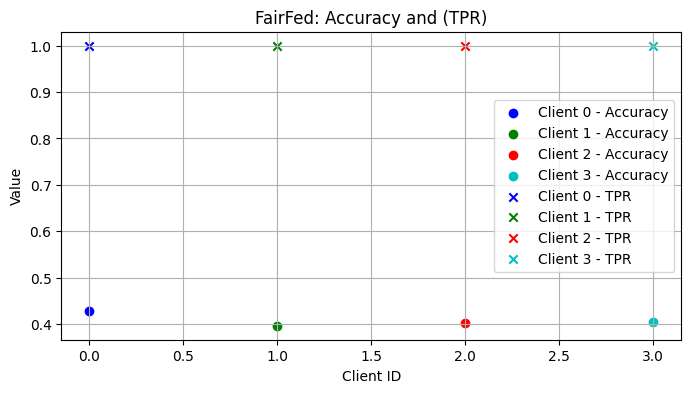

In [21]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_ff['Client ID']):
    ax.scatter(client, df_ff['Accuracy'][i], c=colors[i], marker='o', label=f'Client {client} - Accuracy')

for i, client in enumerate(df_ff['Client ID']):
    ax.scatter(client, df_ff['Recall'][i], c=colors[i], marker='x', label=f'Client {client} - TPR')

ax.set_xlabel('Client ID')
ax.set_ylabel('Value')
ax.set_title('FairFed: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()

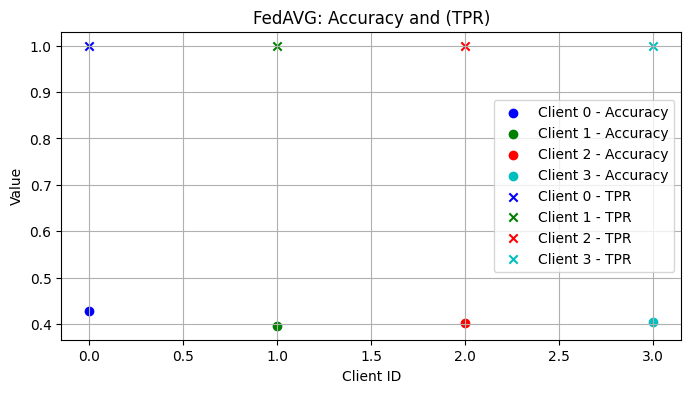

In [22]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_FA['Client ID']):
    ax.scatter(client, df_FA['Accuracy'][i], c=colors[i], marker='o', label=f'Client {client} - Accuracy')

for i, client in enumerate(df_FA['Client ID']):
    ax.scatter(client, df_FA['Recall'][i], c=colors[i], marker='x', label=f'Client {client} - TPR')

ax.set_xlabel('Client ID')
ax.set_ylabel('Value')
ax.set_title('FedAVG: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()

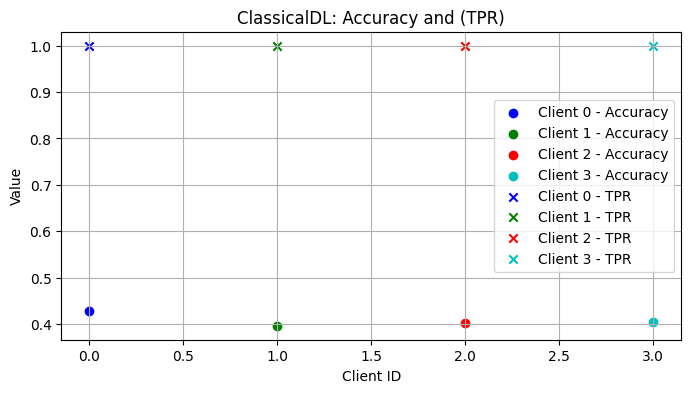

In [23]:

colors = ['b', 'g', 'r', 'c']

fig, ax = plt.subplots(figsize=(8, 4))

for i, client in enumerate(df_CD['Client ID']):
    ax.scatter(client, df_CD['Accuracy'][i], c=colors[i], marker='o', label=f'Client {client} - Accuracy')

for i, client in enumerate(df_CD['Client ID']):
    ax.scatter(client, df_CD['Recall'][i], c=colors[i], marker='x', label=f'Client {client} - TPR')

ax.set_xlabel('Client ID')
ax.set_ylabel('Value')
ax.set_title('ClassicalDL: Accuracy and (TPR)')
ax.legend()

plt.grid(True)
plt.show()